# FakeOrNot Tweets Classification

by Oleg Ovcharuk

Kaggle competition: https://www.kaggle.com/c/nlp-getting-started/overview

## Dataset exploration

Посмотрим из чего состоит датасет, что в нем есть интересного и можем ли мы увидеть в нем какие-либо зависимости.

In [1]:
import pandas as pd
import numpy as np

train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')


In [2]:
print(f"Train shape: {train_dataset.shape}")
print(f"Test shape: {test_dataset.shape}")

Train shape: (7613, 5)
Test shape: (3263, 4)


In [3]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Посмотрим на пример настоящего и фейкового твита:

In [5]:
fake_tweets = train_dataset[train_dataset['target'] == 0]['text'].values
real_tweets = train_dataset[train_dataset['target'] == 1]['text'].values

In [6]:
print(f"Real tweet: {real_tweets[100]}")
print(f"Fake tweet: {fake_tweets[100]}")

Real tweet: Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/X2Qsjod40u #worldnews
Fake tweet: @Kiwi_Karyn Check out what's in my parking lot!! He said that until last year it was an ambulance in St Johns. http://t.co/hPvOdUD7iP


In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

%matplotlib inline

Посмотрим на распределение реальных и фейковых твитов.

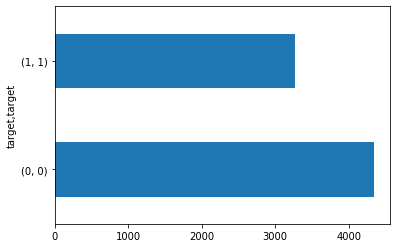

In [8]:
train_dataset.groupby('target').target.value_counts().plot.barh()

Ну, +- одинаково. Для красоты посмотрим на топ слов из настоящих и фейковых твитов.

In [9]:
def print_wordcloud(text):
    wordcloud = WordCloud(width = 2000, height = 1000,
                          background_color = 'white',
                          stopwords = STOPWORDS).generate(str(text))

    fig = plt.figure(figsize = (16, 10), 
                     facecolor = 'k', 
                     edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

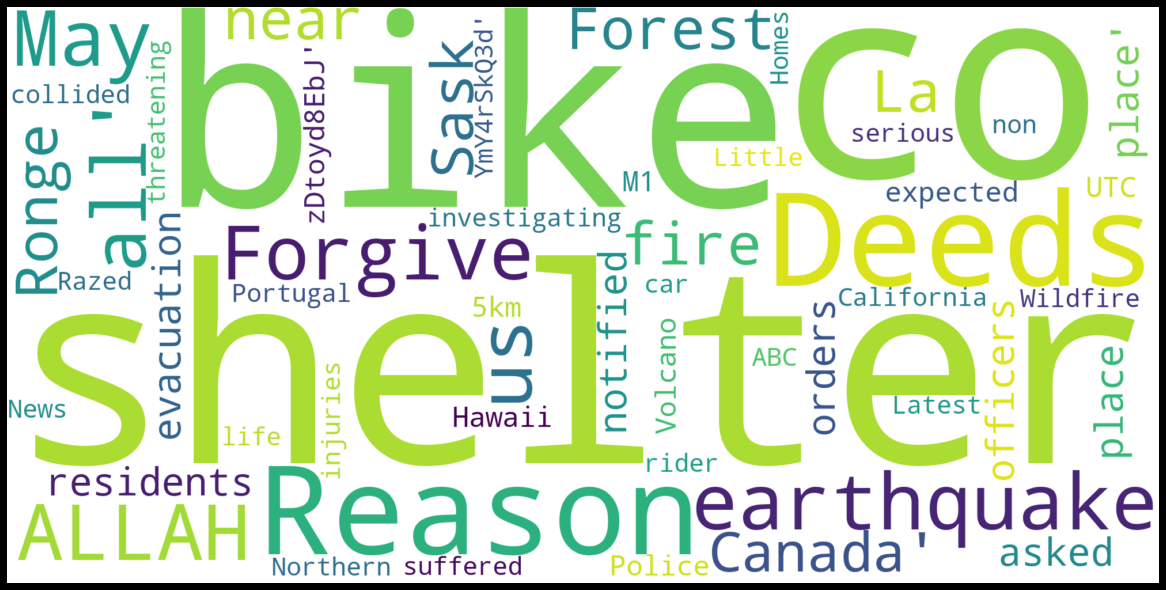

In [10]:
print_wordcloud(real_tweets)

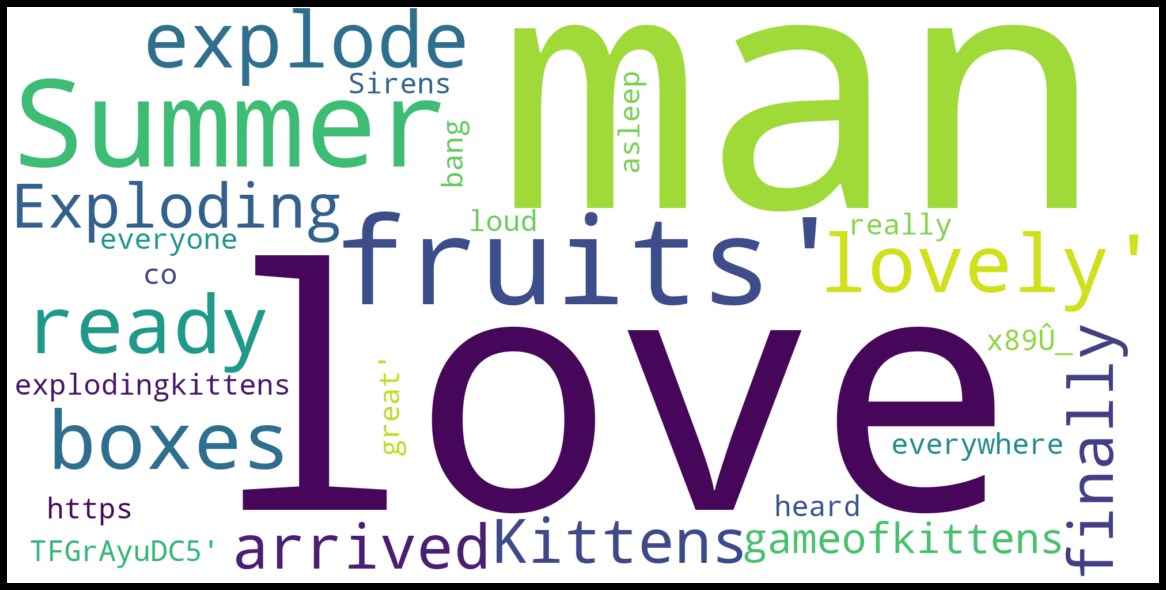

In [11]:
print_wordcloud(fake_tweets)

## Dataset preparation

Самое важное:

In [12]:
SEED = 42

Подготовим наши данные. Предполагается использовать модель DistilBert для переноса обучения, так что нас в данной задаче интересует только текст, избавимся от лишнего, а так же разобьем тренировочный датасет на тренировочный и валидационный.

In [13]:
from sklearn.model_selection import train_test_split

tweets = train_dataset['text'].values
targets = train_dataset['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    tweets, targets, test_size=0.2, random_state = SEED
)

test_tweets = test_dataset['text'].values

In [14]:
import tensorflow as tf

np.random.seed(SEED)
tf.random.set_seed(SEED)

Проверяем, смог ли я наконец заставить видеокарту, купленную **исключительно** для данного проекта, определяться tensorflow:

In [15]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() 
      else "not available")

TF Version:  2.0.0
Eager mode:  True
GPU is available


Отлично, резюме в OpenAI напишу чуть позже, а сейчас подготовим tokenizer для все той же модели и функцию, которая будет подготавливать вход на нашу нейросеть:

In [16]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [17]:
import tqdm

MAX_SEQ_LENGTH = 500

def create_input_features(tokenizer, docs, max_seq_length):
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

Итак, опишем нашу модель:

In [18]:
def build_model():
    # Создаем инпуты и соединяем их с предобученной сеткой
    inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
    inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
    inputs = [inp_id, inp_mask]

    hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
    pooled_output = hidden_state[:, 0]
    
    # Добавляем два полносвязных слоя
    dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
    drop1 = tf.keras.layers.Dropout(0.3)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(0.3)(dense2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                               epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

Посмотрим на нее:

In [19]:
model = build_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 500, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_distil_bert_model[0][0]   

Конвертируем обучающую и валидационную выборку в то что влезет в сетку:

In [20]:
train_features_ids, train_features_masks = create_input_features(
    tokenizer,
    X_train,
    max_seq_length=MAX_SEQ_LENGTH
)

val_features_ids, val_features_masks = create_input_features(
    tokenizer, 
    X_val,
    max_seq_length=MAX_SEQ_LENGTH
)

Converting docs to features: 100%|██████████| 1523/1523 [00:00<00:00, 3443.99it/s]


In [21]:
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Train Features: (6090, 500) (6090, 500)
Val Features: (1523, 500) (1523, 500)


Штош, приступаем к обучению, надеюсь оно посчитается быстро. 

In [22]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit(
    [train_features_ids, train_features_masks], 
    y_train, 
    validation_data=(
        [val_features_ids, val_features_masks], y_val
    ),
    epochs=5, 
    batch_size=9, 
    callbacks=[es],
    shuffle=True,
    verbose=1
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 248s 41ms/sample - loss: 0.4461 - accuracy: 0.8105 - val_loss: 0.3861 - val_accuracy: 0.8359
Epoch 2/5
6090/6090 [==============================] - 241s 40ms/sample - loss: 0.3286 - accuracy: 0.8742 - val_loss: 0.4098 - val_accuracy: 0.8365
Epoch 3/5
6090/6090 [==============================] - 238s 39ms/sample - loss: 0.2307 - accuracy: 0.9138 - val_loss: 0.4808 - val_accuracy: 0.8352
Epoch 4/5
6090/6090 [==============================] - 239s 39ms/sample - loss: 0.1477 - accuracy: 0.9479 - val_loss: 0.5932 - val_accuracy: 0.8286
Epoch 00004: early stopping


Отлично! Получили довольно хорошую точность на валидационной выборке, осталось только сгенерировать предикшн на тестовую выборку и впервые в жизни отправить что-то на каггл!

In [23]:
test_features_ids, test_features_masks = create_input_features(
    tokenizer,
    test_tweets,
    max_seq_length=MAX_SEQ_LENGTH
)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 3263/3263 [00:00<00:00, 3333.34it/s]

Test Features: (3263, 500) (3263, 500)


In [24]:
raw_predictions = model.predict([test_features_ids, test_features_masks]).ravel()

In [25]:
threshold = 0.55

predictions = [1 if prediction > threshold else 0 
               for prediction in raw_predictions]

In [26]:
ids = test_dataset['id']
result = pd.DataFrame(list(zip(ids, predictions)), columns=['id', 'target'])
result.to_csv('submission.csv', index=False)

А вот и результат:

![Score](./submission.png)

![Leaderboard](./leaderboard.png)